In [2]:
import numpy as np 
import pandas as pd

from data import RandomData, AmazonBooks, ToyData, MovieLensData
from model import RandomModel, CombinedMeanModel, ItemItemCollaborationModel

%matplotlib inline

In [3]:
%load_ext autoreload
%autoreload 2

### Load Data

In [4]:
ds = MovieLensData(min_user_ratings=5).get_dataset(verbose=True)
train = ds['train']
val = ds['val']

loading preprocessed dataset from disk


In [6]:
DATA_SOURCE = 'MovieLens5'
model = ItemItemCollaborationModel()
train = ds['train']
val = ds['val']

model.fit(train)
train_up_rat = train['user_product_ratings'].copy()
val_up_rat = val['user_product_ratings'].copy()

val_up_rat['pred'] = model.predict(val_up_rat[['user_id', 'product_id']])    
val_up_rat.to_csv('./' + 'Amazon10' +  'val_up_rat.csv')
print("saved pred CSV")

train_up_rat['pred'] = model.predict(train_up_rat[['user_id', 'product_id']]) 
train_up_rat.to_csv('./' + 'Amazon10' + 'train_up_rat.csv')
print("saved train CSV")


loss_fn = mean_squared_error

train_users = set(train['user_product_ratings'].user_id)
train_products = set(train['user_product_ratings'].product_id)

train_loss = loss_fn(train_up_rat.pred, train_up_rat.rating)

val_loss = loss_fn(val_up_rat.pred, val_up_rat.rating)

A_data = val_up_rat[val_up_rat.user_id.isin(train_users) & 
                    val_up_rat.product_id.isin(train_products)]
A_loss = loss_fn(A_data.pred, A_data.rating)

B_data = val_up_rat[~val_up_rat.user_id.isin(train_users) &
                    val_up_rat.product_id.isin(train_products)]
B_loss = loss_fn(B_data.pred, B_data.rating)

C_data = val_up_rat[val_up_rat.user_id.isin(train_users) &
                    ~val_up_rat.product_id.isin(train_products)]
C_loss = loss_fn(C_data.pred, C_data.rating)

D_data = val_up_rat[~val_up_rat.user_id.isin(train_users) &
                    ~val_up_rat.product_id.isin(train_products)]
D_loss = loss_fn(D_data.pred, D_data.rating)

print('\n'.join(
    ['     Products',
     '    -----------',
     '   |       |   |  (A.x) TRAIN SET',
     ' U | (A.x) |   |  (A.o) VAL CELL HOLDOUT',
     ' s | (A.o) |(C)|    (B) VAL USER HOLDOUT',
     ' e |       |   |    (C) VAL PRODUCT HOLDOUT',
     ' r |       |   |    (D) VAL PRODUCT & USER HOLDOUT',
     ' s |-------|---|    (V) VAL SET',
     '   |  (B)  |(D)|',
     '    -----------',
     '================================',
     '']))

def stats(data, loss, lbl):
    print(lbl)
    print(f'      Number of users: {len(set(data.user_id))}')
    print(f'      Number of proucts: {len(set(data.product_id))}')
    print(f'      Number of ratings: {len(data)}')
    print(f'      loss: {loss}\n')
stats(train_up_rat, train_loss, '(A.x) TRAIN SET')
stats(val_up_rat, val_loss, '  (V) VAL SET')
stats(A_data, A_loss, '(A.o) VAL CELL HOLDOUT')
stats(B_data, B_loss, '  (B) VAL USER HOLDOUT')
stats(C_data, C_loss, '  (C) VAL PRODUCT HOLDOUT')
stats(D_data, D_loss, '  (D) VAL PRODUCT & USER HOLDOUT')

0/2754225
1000/2754225
2000/2754225
3000/2754225
4000/2754225
5000/2754225
6000/2754225
7000/2754225
8000/2754225
9000/2754225
10000/2754225
11000/2754225
12000/2754225
13000/2754225
14000/2754225
15000/2754225
16000/2754225
17000/2754225
18000/2754225
19000/2754225
20000/2754225
21000/2754225
22000/2754225
23000/2754225
24000/2754225
25000/2754225
26000/2754225
27000/2754225
28000/2754225
29000/2754225
30000/2754225
31000/2754225
32000/2754225
33000/2754225
34000/2754225
35000/2754225
36000/2754225
37000/2754225
38000/2754225
39000/2754225
40000/2754225
41000/2754225
42000/2754225
43000/2754225
44000/2754225
45000/2754225
46000/2754225
47000/2754225
48000/2754225
49000/2754225
50000/2754225
51000/2754225
52000/2754225
53000/2754225
54000/2754225
55000/2754225
56000/2754225
57000/2754225
58000/2754225
59000/2754225
60000/2754225
61000/2754225
62000/2754225
63000/2754225
64000/2754225
65000/2754225
66000/2754225
67000/2754225
68000/2754225
69000/2754225
70000/2754225
71000/2754225
72000

554000/2754225
555000/2754225
556000/2754225
557000/2754225
558000/2754225
559000/2754225
560000/2754225
561000/2754225
562000/2754225
563000/2754225
564000/2754225
565000/2754225
566000/2754225
567000/2754225
568000/2754225
569000/2754225
570000/2754225
571000/2754225
572000/2754225
573000/2754225
574000/2754225
575000/2754225
576000/2754225
577000/2754225
578000/2754225
579000/2754225
580000/2754225
581000/2754225
582000/2754225
583000/2754225
584000/2754225
585000/2754225
586000/2754225
587000/2754225
588000/2754225
589000/2754225
590000/2754225
591000/2754225
592000/2754225
593000/2754225
594000/2754225
595000/2754225
596000/2754225
597000/2754225
598000/2754225
599000/2754225
600000/2754225
601000/2754225
602000/2754225
603000/2754225
604000/2754225
605000/2754225
606000/2754225
607000/2754225
608000/2754225
609000/2754225
610000/2754225
611000/2754225
612000/2754225
613000/2754225
614000/2754225
615000/2754225
616000/2754225
617000/2754225
618000/2754225
619000/2754225
620000/275

1112000/2754225
1113000/2754225
1114000/2754225
1115000/2754225
1116000/2754225
1117000/2754225
1118000/2754225
1119000/2754225
1120000/2754225
1121000/2754225
1122000/2754225
1123000/2754225
1124000/2754225
1125000/2754225
1126000/2754225
1127000/2754225
1128000/2754225
1147000/2754225
1148000/2754225
1149000/2754225
1150000/2754225
1151000/2754225
1152000/2754225
1153000/2754225
1154000/2754225
1155000/2754225
1156000/2754225
1157000/2754225
1158000/2754225
1159000/2754225
1160000/2754225
1161000/2754225
1162000/2754225
1163000/2754225
1164000/2754225
1165000/2754225
1166000/2754225
1167000/2754225
1168000/2754225
1169000/2754225
1170000/2754225
1171000/2754225
1172000/2754225
1173000/2754225
1174000/2754225
1175000/2754225
1176000/2754225
1177000/2754225
1178000/2754225
1179000/2754225
1180000/2754225
1181000/2754225
1182000/2754225
1183000/2754225
1184000/2754225
1185000/2754225
1186000/2754225
1187000/2754225
1188000/2754225
1189000/2754225
1190000/2754225
1191000/2754225
1192000/

1643000/2754225
1644000/2754225
1645000/2754225
1646000/2754225
1647000/2754225
1648000/2754225
1649000/2754225
1650000/2754225
1651000/2754225
1652000/2754225
1653000/2754225
1654000/2754225
1655000/2754225
1656000/2754225
1657000/2754225
1658000/2754225
1659000/2754225
1660000/2754225
1661000/2754225
1662000/2754225
1663000/2754225
1664000/2754225
1665000/2754225
1666000/2754225
1667000/2754225
1668000/2754225
1669000/2754225
1670000/2754225
1671000/2754225
1672000/2754225
1673000/2754225
1674000/2754225
1675000/2754225
1676000/2754225
1677000/2754225
1678000/2754225
1679000/2754225
1680000/2754225
1681000/2754225
1682000/2754225
1683000/2754225
1684000/2754225
1685000/2754225
1686000/2754225
1687000/2754225
1688000/2754225
1689000/2754225
1690000/2754225
1691000/2754225
1692000/2754225
1693000/2754225
1694000/2754225
1695000/2754225
1696000/2754225
1697000/2754225
1698000/2754225
1699000/2754225
1700000/2754225
1701000/2754225
1702000/2754225
1703000/2754225
1704000/2754225
1705000/

2156000/2754225
2157000/2754225
2158000/2754225
2159000/2754225
2160000/2754225
2161000/2754225
2162000/2754225
2163000/2754225
2164000/2754225
2165000/2754225
2166000/2754225
2167000/2754225
2168000/2754225
2169000/2754225
2170000/2754225
2171000/2754225
2172000/2754225
2173000/2754225
2174000/2754225
2175000/2754225
2176000/2754225
2177000/2754225
2178000/2754225
2179000/2754225
2180000/2754225
2181000/2754225
2182000/2754225
2183000/2754225
2184000/2754225
2185000/2754225
2186000/2754225
2187000/2754225
2188000/2754225
2189000/2754225
2190000/2754225
2191000/2754225
2192000/2754225
2193000/2754225
2194000/2754225
2195000/2754225
2196000/2754225
2197000/2754225
2198000/2754225
2199000/2754225
2200000/2754225
2201000/2754225
2202000/2754225
2203000/2754225
2204000/2754225
2205000/2754225
2206000/2754225
2207000/2754225
2208000/2754225
2209000/2754225
2210000/2754225
2211000/2754225
2212000/2754225
2213000/2754225
2214000/2754225
2215000/2754225
2216000/2754225
2217000/2754225
2218000/

2669000/2754225
2670000/2754225
2671000/2754225
2672000/2754225
2673000/2754225
2674000/2754225
2675000/2754225
2676000/2754225
2677000/2754225
2678000/2754225
2679000/2754225
2680000/2754225
2681000/2754225
2682000/2754225
2683000/2754225
2684000/2754225
2685000/2754225
2686000/2754225
2687000/2754225
2688000/2754225
2689000/2754225
2690000/2754225
2691000/2754225
2692000/2754225
2693000/2754225
2694000/2754225
2695000/2754225
2696000/2754225
2697000/2754225
2698000/2754225
2699000/2754225
2700000/2754225
2701000/2754225
2702000/2754225
2703000/2754225
2704000/2754225
2705000/2754225
2706000/2754225
2707000/2754225
2708000/2754225
2709000/2754225
2710000/2754225
2711000/2754225
2712000/2754225
2713000/2754225
2714000/2754225
2715000/2754225
2716000/2754225
2717000/2754225
2718000/2754225
2719000/2754225
2720000/2754225
2721000/2754225
2722000/2754225
2723000/2754225
2724000/2754225
2725000/2754225
2726000/2754225
2727000/2754225
2728000/2754225
2729000/2754225
2730000/2754225
2731000/

KeyboardInterrupt: 

## clustering

In [8]:
grouped_reviews = ds['train']['user_product_ratings'].groupby('user_id')['user_id', 'product_id', 'rating']
num_users = len(grouped_reviews.groups.keys())
print(num_users)

31850


In [9]:
from data import RandomData, AmazonBooks, ToyData, MovieLensData
from clustering import ClusteringModel

from math import floor 

%matplotlib inline
%load_ext autoreload
%autoreload 2

# ds = MovieLensData(min_user_ratings=5).get_dataset(verbose=True)
c_model = ClusteringModel(num_clusters=floor(num_users/100), num_iterations=200)
c_model.fit(train)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


KeyboardInterrupt: 

In [17]:
import pickle
pickle.dump(c_model.clusters, open("Amazon5_clusters_n318_iter200.p", 'wb'))

In [18]:
pickle.dump(c_model.users, open("Amazon5_users_n318_iter200.p", 'wb'))

In [4]:
(len(ds['test']['user_product_ratings']),
 len(ds['val']['user_product_ratings']),
 len(ds['train']['user_product_ratings']))

(2702933, 2754434, 5097362)

In [5]:
train['user_product_ratings'].rating.value_counts()

4.0    1435242
3.0    1043209
5.0    1021570
3.5     435754
4.5     427696
2.0     297769
1.0     162929
2.5     150745
0.5      67362
1.5      55086
Name: rating, dtype: int64

In [6]:
len(set(ds['train']['user_product_ratings'].user_id))

179307

In [7]:
len(set(ds['val']['user_product_ratings'].user_id))

214990

In [8]:
(len(ds['test']['product_descriptions']),
 len(ds['val']['product_descriptions']),
 len(ds['train']['product_descriptions']))

(11046, 11120, 10640)

In [9]:
(len(ds['test']['product_reviews']),
 len(ds['val']['product_reviews']),
 len(ds['train']['product_reviews']))

(73038, 72454, 88503)

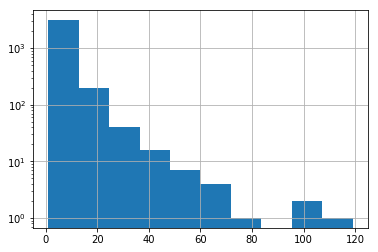

In [10]:
ds['train']['user_product_ratings'].groupby('user_id')['rating'].count().hist(log=True)

### Accuracy Metrics

In [11]:
def mean_squared_error(pred, ground_truth):
    return np.mean((pred - ground_truth) ** 2.)

In [12]:
def accuracy(pred, ground_truth):
    return (np.round(pred) == ground_truth).sum() / float(len(pred))

In [13]:
def evaluate_model(model, train, val, loss_fn):
    model.fit(train)
    train_up_rat = train['user_product_ratings']
    val_up_rat = val['user_product_ratings'].copy()
    val_up_rat['pred'] = model.predict(val_up_rat[['user_id', 'product_id']])
    
    train_users = set(train['user_product_ratings'].user_id)
    train_products = set(train['user_product_ratings'].product_id)
    
    train_loss = loss_fn(model.predict(train_up_rat[['user_id', 'product_id']]),
                         train_up_rat.rating)
    
    val_loss = loss_fn(model.predict(val_up_rat[['user_id', 'product_id']]),
                       val_up_rat.rating)
    
    A_data = val_up_rat[val_up_rat.user_id.isin(train_users) & 
                        val_up_rat.product_id.isin(train_products)]
    A_loss = loss_fn(A_data.pred, A_data.rating)
    
    B_data = val_up_rat[~val_up_rat.user_id.isin(train_users) &
                        val_up_rat.product_id.isin(train_products)]
    B_loss = loss_fn(B_data.pred, B_data.rating)
    
    C_data = val_up_rat[val_up_rat.user_id.isin(train_users) &
                        ~val_up_rat.product_id.isin(train_products)]
    C_loss = loss_fn(C_data.pred, C_data.rating)
    
    D_data = val_up_rat[~val_up_rat.user_id.isin(train_users) &
                        ~val_up_rat.product_id.isin(train_products)]
    D_loss = loss_fn(D_data.pred, D_data.rating)
    
    print('\n'.join(
        ['     Products',
         '    -----------',
         '   |       |   |  (A.x) TRAIN SET',
         ' U | (A.x) |   |  (A.o) VAL CELL HOLDOUT',
         ' s | (A.o) |(C)|    (B) VAL USER HOLDOUT',
         ' e |       |   |    (C) VAL PRODUCT HOLDOUT',
         ' r |       |   |    (D) VAL PRODUCT & USER HOLDOUT',
         ' s |-------|---|    (V) VAL SET',
         '   |  (B)  |(D)|',
         '    -----------',
         '================================',
         '']))
    
    def stats(data, loss, lbl):
        print(lbl)
        print(f'      Number of users: {len(set(data.user_id))}')
        print(f'      Number of proucts: {len(set(data.product_id))}')
        print(f'      Number of ratings: {len(data)}')
        print(f'      loss: {loss}\n')
    stats(train_up_rat, train_loss, '(A.x) TRAIN SET')
    stats(val_up_rat, val_loss, '  (V) VAL SET')
    stats(A_data, A_loss, '(A.o) VAL CELL HOLDOUT')
    stats(B_data, B_loss, '  (B) VAL USER HOLDOUT')
    stats(C_data, C_loss, '  (C) VAL PRODUCT HOLDOUT')
    stats(D_data, D_loss, '  (D) VAL PRODUCT & USER HOLDOUT')
    return val_loss, A_loss, B_loss, C_loss, D_loss

In [14]:
model = ItemItemCollaborationModel()
_ = evaluate_model(model, train, val, mean_squared_error)

NameError: name 'users' is not defined

In [ ]:
model = SimpleMeanModel()
_ = evaluate_model(model, train, val, mean_squared_error)

In [15]:
model = UserMeanModel()
_ = evaluate_model(model, train, val, mean_squared_error)

NameError: name 'UserMeanModel' is not defined

In [16]:
model = ProductMeanModel()
_ = evaluate_model(model, train, val, mean_squared_error)

NameError: name 'ProductMeanModel' is not defined

In [17]:
model = CombinedMeanModel()
_ = evaluate_model(model, train, val, mean_squared_error)

     Products
    -----------
   |       |   |  (A.x) TRAIN SET
 U | (A.x) |   |  (A.o) VAL CELL HOLDOUT
 s | (A.o) |(C)|    (B) VAL USER HOLDOUT
 e |       |   |    (C) VAL PRODUCT HOLDOUT
 r |       |   |    (D) VAL PRODUCT & USER HOLDOUT
 s |-------|---|    (V) VAL SET
   |  (B)  |(D)|
    -----------

(A.x) TRAIN SET
      Number of users: 3381
      Number of proucts: 9088
      Number of ratings: 21175
      loss: 0.30779498747098

  (V) VAL SET
      Number of users: 3404
      Number of proucts: 6431
      Number of ratings: 11588
      loss: 1.0806971070500666

(A.o) VAL CELL HOLDOUT
      Number of users: 1491
      Number of proucts: 1827
      Number of ratings: 2195
      loss: 1.2075150970715742

  (B) VAL USER HOLDOUT
      Number of users: 619
      Number of proucts: 2424
      Number of ratings: 3175
      loss: 1.1184449993859649

  (C) VAL PRODUCT HOLDOUT
      Number of users: 2117
      Number of proucts: 1912
      Number of ratings: 4131
      loss: 0.9888275083

In [11]:
import model
import imp
imp.reload(model)

<module 'model' from '/Users/gili/Documents/stanford/junior/cs224u/cs224u/cs224u_project/model.py'>

In [126]:
import csv
def load_glove(glove_data_file):
        words = pd.read_table(glove_data_file, sep=" ", index_col=0, header=None, quoting=csv.QUOTE_NONE)
        return words

def convert_word_to_vec(model, w, embed_size, verbose=True):
    if w in model.index:
        if verbose: 
            print("found")
        return model.loc[w].as_matrix()
    else:
        if verbose: 
            print("not found")
        return np.random.normal(0, 0.7, embed_size)


import matplotlib.pyplot as plt
def randomly_sample(model):
    all_words = []
    count = 0
    for w in model.index:
        all_words.append(model.loc[w].as_matrix())
        if count > 1000:
            plt.hist(np.array(all_words).flatten())
            return
        count += 1
    
import os
def create_vsm(corpus, embed_size=50, glove_file_path='glove.6B'):
    vsm_list = []
    vocab = set(corpus)
    assert(embed_size == 50 or embed_size==100)
    glove_file = os.path.join(glove_file_path, 'glove.6B.%dd.txt' % embed_size)
    model = None
    model = load_glove(glove_file)
    if model is not None:
        for word in vocab:
            word_as_vec = convert_word_to_vec(model, word, embed_size)
            vsm_list.append(word_as_vec)
    return np.array(vsm_list)


In [130]:
# Testing vsms
test_1 = create_vsm(['hi', 'bye', 'can', 'not', 'more', 'words', 'next', 'other', 'work', 'bye', 'can', 'not', 'more', 'words', 'next', 'other', 'work'], embed_size=100)
test_2 = create_vsm(['hi', 'bye', 'askfdklsd'], embed_size=100)
test_3 = create_vsm(['lkadsfj', 'hello', 'be'], embed_size=50)
test_4 = create_vsm(['hi', 'askfdklsd', 'bye'], embed_size=100)
#test_5 = create_vsm(['hi'], embed_size = 60)
print(test_1)
print(test_2)

found
found
found
found
found
found
found
found
found
found
found
not found
not found
found
found
found
found
not found
[[ 7.2607e-02  7.0889e-01  4.2583e-01 -5.6344e-02 -2.7468e-01  1.0245e+00
  -3.4179e-01 -8.0244e-01 -1.7076e-01 -3.4955e-01 -3.3893e-02  1.5975e-01
   1.1722e-01  4.6308e-01 -2.1898e-01 -1.1145e-01 -2.5906e-01 -1.6977e-01
  -6.1767e-01 -2.5274e-01  6.7205e-01 -2.2908e-01 -1.5565e-01  8.5560e-03
   2.2689e-01 -1.3908e-01 -5.4157e-02  1.0742e-01  2.3514e-01 -8.9140e-02
   1.4436e-01  7.9394e-01 -5.7136e-01 -2.5193e-01 -3.9158e-01 -1.3934e-01
  -3.8139e-01 -9.4135e-02  2.6057e-01  7.7475e-02 -1.4822e-01 -4.1464e-01
   2.5563e-03  4.4005e-02 -7.7818e-01 -1.5953e-01 -6.1808e-02 -3.9439e-01
  -5.2755e-01 -6.2012e-01  7.1911e-01 -1.0982e-02  1.1115e+00  8.0687e-01
  -3.1538e-01 -1.6293e+00  3.3266e-02 -6.3853e-02  6.1646e-01 -1.0547e-01
   3.5890e-01  1.4457e+00 -4.6421e-01 -7.5587e-01  6.4232e-01 -1.6544e-01
   9.0204e-01  1.5494e-01 -2.8529e-02 -7.4347e-01 -5.7556e-01  4.2

In [ ]:
model = load_glove('glove.6B/glove.6B.100d.txt')
randomly_sample(model)

In [108]:
ls = []
ls.append(np.array([4,5,6]))
ls.append([1,2,3])


In [109]:
np.array(ls)

array([[4, 5, 6],
       [1, 2, 3]])

In [129]:
import codecs
from collections import defaultdict
import itertools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import scipy
import scipy.spatial.distance
import sys
def lsa(df, k=100):
    """Latent Semantic Analysis using pure scipy.
    Parameters
    ----------
    df : pd.DataFrame
       The matrix to operate on.
    k : int (default: 100)
        Number of dimensions to truncate to.
    Returns
    -------
    pd.DataFrame
        The SVD-reduced version of `df` with dimension (m x k), where
        m is the rowcount of mat and `k` is either the user-supplied
        k or the column count of `mat`, whichever is smaller.
    """
    rowmat, singvals, colmat = np.linalg.svd(df, full_matrices=False)
    singvals = np.diag(singvals)
    trunc = np.dot(rowmat[:, 0:k], singvals[0:k, 0:k])
    return pd.DataFrame(trunc, index=df.index)


In [ ]:
def create_vsm(corpus, embed_size=50):
    lsa()